In [ ]:
!pip install openai
!pip install yfinance
!pip install mplfinance
!pip install backtesting


In [ ]:

from openai import OpenAI, OpenAIError
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import mplfinance as mpf
import yfinance as yf
import pandas as pd
import datetime as dt


In [ ]:
stock_id = "META"
end = dt.date.today() # end time
start = end - dt.timedelta(days =180) # start time
StockData = yf.download(stock_id, start , end).reset_index()


[*********************100%%**********************]  1 of 1 completed


Use OpenAI to write calculate function

In [ ]:
import getpass
api_key = ""
client = OpenAI(api_key = api_key)

In [ ]:
def get_reply(messages):
  try:
    response = client.chat.completions.create(model="gpt-3.5-turbo", messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply
def ai_helper(StockData, user_msg):
  msg = [{"role":"system","content":
      f"I require your assistance in generating Python code based on specific user requirements.\
      Your need to carefully analyze user's requirements and generate the Python code.\
      I will provide you with a dataframe (StockData) that follows the format {StockData.columns}.\
      Please note that your response should solely consist of the code itself,and no additional information should be included."},
      {"role":"user","content":
      f"The user requirement:{user_msg} \n\
      Your task is to develop a Python function named \
      'calculate(StockData)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {StockData.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(StockData)' function \
      and exclude any unrelated content."
      }]
  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```","")
  cleaned_code = cleaned_code.replace("python","")

  return cleaned_code
def ai_helper_strategy(StockData, user_msg):
  msg = [{"role":"system","content":
      f"I require your assistance in generating Python code based on specific user requirements.\
      Your need to carefully analyze user's requirements and generate the Python code.\
      I will provide you with a dataframe (StockData) that follows the format {StockData.columns}.\
      Please note that your response should solely consist of the code itself,and no additional information should be included."},
      {"role":"user","content":
      f"The user requirement:{user_msg} \n\
      Your task is to develop a Python function named \
      'calculate(StockData)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {StockData.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(StockData)' function \
      and exclude any unrelated content."
      }]
  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```","")
  cleaned_code = cleaned_code.replace("python","")

  return cleaned_code

In [ ]:
code_str = ai_helper(StockData,"1. calculate MACD and named it as MACD_Histogram, 2. Calculating Bollinger Bands and named it as Upper_Band and Lower_Band")
# customize your need
print(code_str)
exec(code_str)
new_StockData = calculate(StockData) ## AI generated code
new_StockData.tail()

def calculate(StockData):
    StockData['MACD'] = StockData['Close'].ewm(span=12, adjust=False).mean() - StockData['Close'].ewm(span=26, adjust=False).mean()
    StockData['Signal_Line'] = StockData['MACD'].ewm(span=9, adjust=False).mean()
    StockData['MACD_Histogram'] = StockData['MACD'] - StockData['Signal_Line']

    StockData['MA20'] = StockData['Close'].rolling(window=20).mean()
    StockData['20 Day STD'] = StockData['Close'].rolling(window=20).std()
    StockData['Upper_Band'] = StockData['MA20'] + (StockData['20 Day STD'] * 2)
    StockData['Lower_Band'] = StockData['MA20'] - (StockData['20 Day STD'] * 2)

    return StockData


,Date,Open,High,Low,Close,Adj Close,Volume,MACD,Signal_Line,MACD_Histogram,MA20,20 Day STD,Upper_Band,Lower_Band
110,2024-06-17,276.5,282.0,262.0,262.0,262.0,39738684,-3.837840,-8.627425,4.789585,241.700,10.170132,262.040263,221.359737
111,2024-06-18,263.5,273.0,257.0,270.0,270.0,16688049,-1.778024,-7.257545,5.479521,242.650,11.835606,266.321213,218.978787
112,2024-06-19,274.0,289.5,264.5,282.5,282.5,34073007,0.853206,-5.635395,6.488600,244.325,14.784660,273.894321,214.755679
113,2024-06-20,289.5,309.0,288.0,297.0,297.0,44035198,4.061682,-3.695979,7.757662,247.075,18.877915,284.830829,209.319171
114,2024-06-21,296.5,307.0,295.0,302.0,302.0,25556506,6.928019,-1.571180,8.499199,250.375,22.298734,294.972469,205.777531


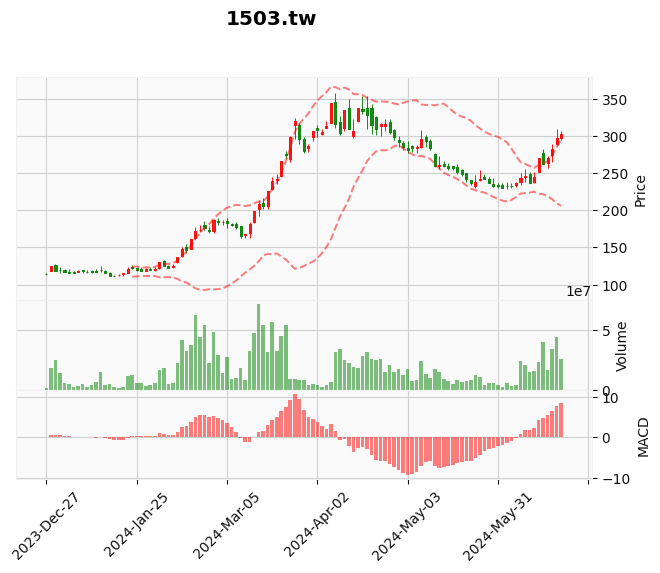

In [ ]:
kplot_StockData = new_StockData.set_index('Date')
end = dt.date.today() # end time
start = end - dt.timedelta(days =180) # start time
kplot_StockData = kplot_StockData[start:end]
kplot_StockData.tail()
# set drawing style
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=my_color)

ap = [
mpf.make_addplot(kplot_StockData['Upper_Band'], color='red',alpha=0.5, linestyle='--'),
mpf.make_addplot(kplot_StockData['Lower_Band'], color='red',alpha=0.5, linestyle='--'),
mpf.make_addplot(kplot_StockData['Volume'], panel=1, type='bar',color='g', alpha=0.5, ylabel='Volume'),
mpf.make_addplot(kplot_StockData['MACD_Histogram'], panel=2, type='bar',color='r', alpha=0.5, ylabel='MACD')]
mpf.plot(kplot_StockData, type='candle', addplot=ap,style=my_style, title=f'{stock_id}')

BackTest your Strategy

In [ ]:
class CrossStrategy(Strategy):
  def init(self):
    super().init()

  def next(self):
    if crossover(self.data.ma1, self.data.ma2):
      self.buy(size=1)
    elif crossover(self.data.ma2, self.data.ma1):
      self.sell(size=1)

In [ ]:

df = yf.download(stock_id, period="1y")

df['ma1'] = df['Close'].rolling(window=5).mean()
df['ma2'] = df['Close'].rolling(window=10).mean()
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ma1,ma2
Date,,,,,,,,
2023-06-22,279.079987,285.260010,277.790009,284.880005,284.295807,17563100,NaN,NaN
2023-06-23,281.510010,289.670013,278.950012,288.730011,288.137909,50988400,NaN,NaN
2023-06-26,288.700012,289.790009,277.600006,278.470001,277.898926,24232700,NaN,NaN
2023-06-27,282.010010,289.350006,280.649994,287.049988,286.461334,26108300,NaN,NaN
2023-06-28,284.820007,289.549988,284.059998,285.290009,284.704987,16722100,284.884003,NaN


In [ ]:
backtest = Backtest(df,
        CrossStrategy,
        cash=100000, # starting fund
        commission=0.004,
        margin=1, # leverage
        hedging=False,
        trade_on_close=False,
        exclusive_orders=False,
        )
stats = backtest.run()

print(stats)
# detailed trading record
stats["_trades"].head()

Start                     2023-06-22 00:00:00
End                       2024-06-21 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                   35.714286
Equity Final [$]                 99920.941517
Equity Peak [$]                 100009.303932
Return [%]                          -0.079058
Buy & Hold Return [%]               73.680143
Return (Ann.) [%]                   -0.079058
Volatility (Ann.) [%]                0.084406
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.127635
Avg. Drawdown [%]                   -0.060581
Max. Drawdown Duration      239 days 00:00:00
Avg. Drawdown Duration      111 days 00:00:00
# Trades                                   10
Win Rate [%]                             30.0
Best Trade [%]                       7.501205
Worst Trade [%]                     -9.073407
Avg. Trade [%]                    

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-1,22,27,294.009242,317.540009,-23.530766,-0.080034,2023-07-25,2023-08-01,7 days
1,-1,33,48,311.628485,297.170013,14.458471,0.046397,2023-08-09,2023-08-30,21 days
2,-1,64,71,298.102788,304.260010,-6.157222,-0.020655,2023-09-22,2023-10-03,11 days
3,-1,84,94,312.883455,312.549988,0.333467,0.001066,2023-10-20,2023-11-03,14 days
4,-1,113,121,324.178091,333.929993,-9.751902,-0.030082,2023-12-01,2023-12-13,12 days
